In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
2


In [7]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

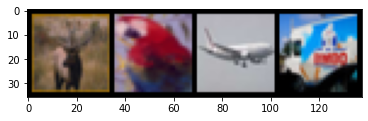

deer bird plane truck


In [9]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

In [10]:
import torch.nn as nn

class FirstCNN(nn.Module):
    def __init__(self): 
        super(FirstCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1), stride=(2,2)) # padding=(1,1), stride=(2,2))
        
    def forward(self, x):
        x = self.conv1(x)
        return x
net = FirstCNN()
out = net(images)
out.shape

torch.Size([4, 16, 16, 16])

In [11]:
out1 = out[0, 0, :, :].detach().numpy()
print(out1.shape)

(16, 16)


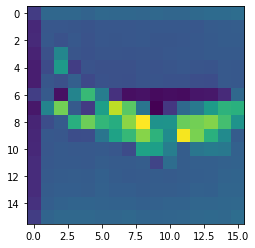

In [12]:
plt.imshow(out[2, 1, :, :].detach().numpy())
plt.show()

In [13]:
class FirstCNN_v2(nn.Module):
    def __init__(self): 
        super(FirstCNN_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, 3),   # (N, 3, 32, 32) -> (N, 8, 30, 30)
            nn.Conv2d(8, 16, 3)   # (N, 8, 30, 30) -> (N, 16, 28, 28)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

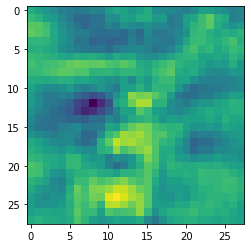

In [14]:
plt.imshow(out[0, 0, :, :].detach().numpy())

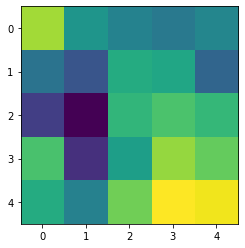

In [15]:
class FirstCNN_v3(nn.Module):
    def __init__(self): 
        super(FirstCNN_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x
net = FirstCNN_v3()
out = net(images)
out.shape
plt.imshow(out[0, 0, :, :].detach().numpy())

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [67]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
import torch.optim as optim
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),eps=1e-08,weight_decay=0.001)

In [75]:
%%time
loss_train=[]
loss_test=[]
max_epochs = 40                                                      

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

    loss_train.append(evaluation(trainloader))
    loss_test.append(evaluation(testloader))

    # loss_trainsum=0
    # for data in trainloader:
    #   inputs,labels=data
    #   inputs, labels = inputs.to(device), labels.to(device)
    #   loss_trainsum+=loss_fn( net(inputs), labels).item()
    
    # loss_train.append(loss_trainsum)

    # loss_testsum=0
    # for data in testloader:
    #   inputs,labels=data
    #   inputs, labels = inputs.to(device), labels.to(device)
    #   loss_testsum+=loss_fn( net(inputs), labels).item()
    # loss_test.append(loss_testsum)


    print('Epoch: %d/%d' % (epoch, max_epochs))

Epoch: 0/40
Epoch: 1/40
Epoch: 2/40
Epoch: 3/40
Epoch: 4/40
Epoch: 5/40
Epoch: 6/40
Epoch: 7/40
Epoch: 8/40
Epoch: 9/40
Epoch: 10/40
Epoch: 11/40
Epoch: 12/40
Epoch: 13/40
Epoch: 14/40
Epoch: 15/40
Epoch: 16/40
Epoch: 17/40
Epoch: 18/40
Epoch: 19/40
Epoch: 20/40
Epoch: 21/40
Epoch: 22/40
Epoch: 23/40
Epoch: 24/40
Epoch: 25/40
Epoch: 26/40
Epoch: 27/40
Epoch: 28/40
Epoch: 29/40
Epoch: 30/40
Epoch: 31/40
Epoch: 32/40
Epoch: 33/40
Epoch: 34/40
Epoch: 35/40
Epoch: 36/40
Epoch: 37/40
Epoch: 38/40
Epoch: 39/40
CPU times: user 11min 27s, sys: 11.3 s, total: 11min 39s
Wall time: 11min 40s


In [76]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

Test acc: 61.38, Train acc: 69.55


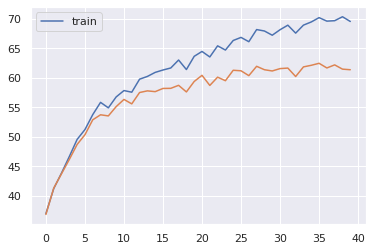

In [77]:
import seaborn as sns
sns.set()
plt.plot(loss_train,label='train')
plt.plot(loss_test)
plt.legend()

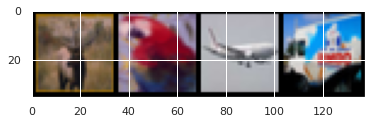

In [86]:
imshow(torchvision.utils.make_grid(images))

In [0]:
net = net.to('cpu')

In [88]:
out = net(images)
print(out.shape)

torch.Size([4, 10])


In [95]:
out = net.cnn_model[0:4](images)
out.shape

torch.Size([4, 16, 10, 10])

In [0]:
from PIL import Image

In [0]:
tt=Image.open('/content/02-cat-training-NationalGeographic_1484324.jpg')

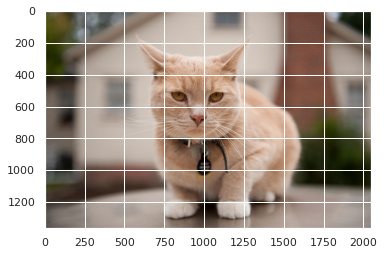

In [290]:
plt.imshow(np.array(tt))

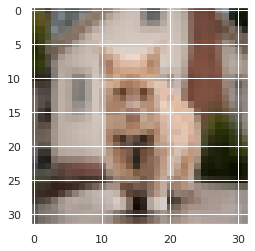

In [291]:
zz=tt.resize((32,32))
plt.imshow(np.array(zz))

In [0]:
zz=np.array(zz)/255

In [0]:
pre_wtf=torch.from_numpy(np.transpose(zz, (2, 1, 0) ) ).float()

In [0]:
wtf=pre_wtf

In [0]:
res=net(torch.from_numpy(np.array([np.transpose(np.array(wtf), (0, 1, 2)  )])))

In [300]:
classes[res.argmax().item()]

'cat'

<BarContainer object of 10 artists>

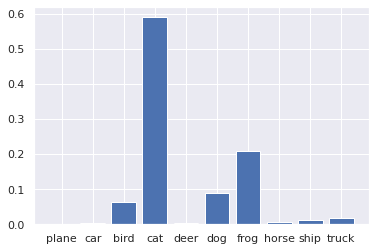

In [301]:
plt.bar(classes,torch.nn.functional.softmax(res,dim=1)[0].tolist())

#Shapley Values

In [304]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394113 sha256=42f1fc6efe6688a9effac91d484051156244a571e2d8a73f97ef37a5d644134d
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [306]:
torch.from_numpy(np.array([np.transpose(np.array(wtf), (0, 1, 2)  )]))

torch.Size([1, 3, 32, 32])

In [439]:
batch = next(iter(trainloader))
images, labels = batch

batch = next(iter(testloader))
images2, labels2 = batch

images=torch.cat((images,images2))
labels=torch.cat((labels,labels))

images.size()

torch.Size([256, 3, 32, 32])

In [413]:
background = images
e = shap.DeepExplainer(net, background)
e

In [0]:
n_test_images = 2
test_images = images[120:120+n_test_images]
shap_values = e.shap_values(test_images)

In [0]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

<Figure size 1440x360 with 0 Axes>

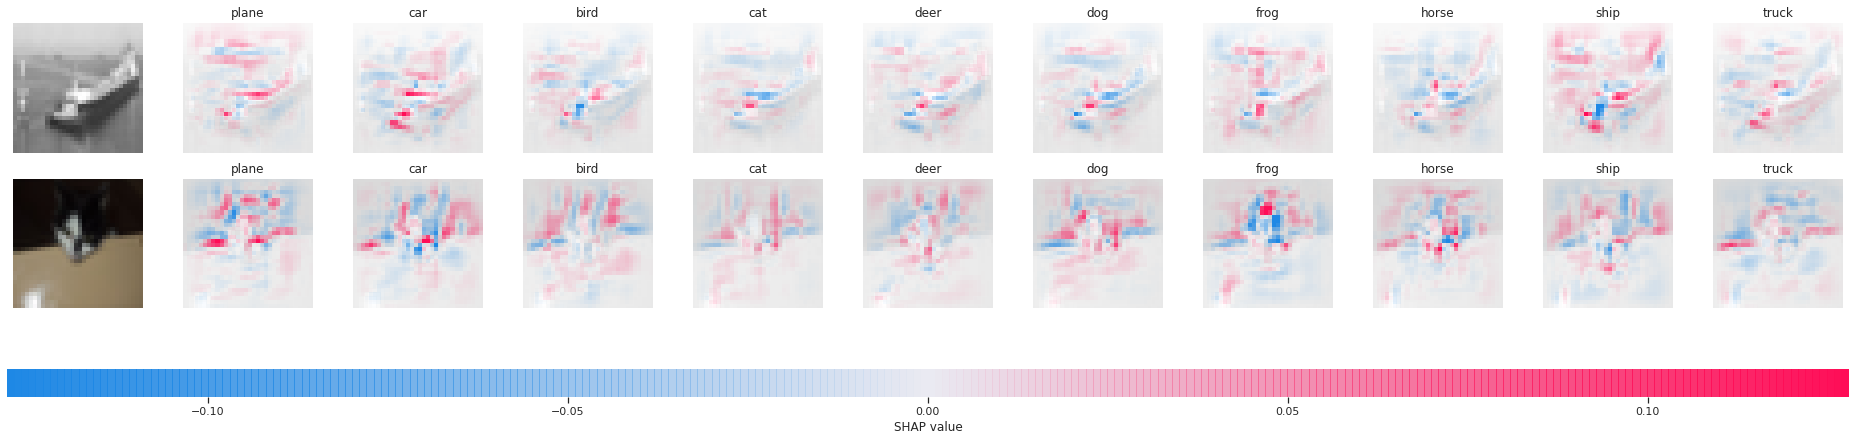

In [437]:
plt.figure(figsize=(20,5))
shap.image_plot(shap_numpy,test_numpy,aspect=0.5,width=50,labels=np.array([np.array(classes) for  x in range(0,n_test_images)]))

<BarContainer object of 10 artists>

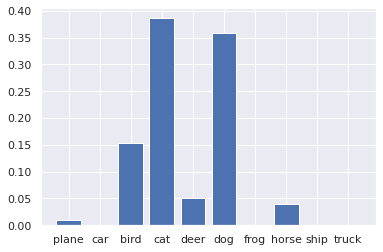

In [438]:
res=net(torch.from_numpy(np.array([np.transpose(np.array(test_numpy[1]), (2, 0, 1)  )])))
plt.bar(classes,torch.nn.functional.softmax(res,dim=1)[0].tolist())